# Digit recognation MNIST Dataset

## 1. Imports

In [14]:
import torch
import torchvision
import matplotlib.pyplot as plt
import requests
import PIL
from torch import nn
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from pathlib import Path
from tqdm.auto import tqdm
from typing import Dict, List

In [15]:
!pip install torchmetrics

In [16]:
import torchmetrics

In [17]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 2. Downloading train and test datasets using the torchvision

In [18]:
root = Path('./data')
if not root.is_dir():
  print('Creating the "data" folder...')
  root.mkdir()
else:
  print('Folder "Data" already exist')


Folder "Data" already exist


In [19]:
train_dir = root / 'train'
test_dir = root / 'test'

train_dir, test_dir

(PosixPath('data/train'), PosixPath('data/test'))

In [20]:
# Get train and test datasets
train_dataset = MNIST(str(train_dir),
                      train=True,
                      download=True,
                      transform=transforms.ToTensor())

test_dataset = MNIST(root=str(test_dir),
                     train=False,
                     download=True,
                     transform=transforms.ToTensor())


In [21]:
train_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data/train
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data/test
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [22]:
classes = train_dataset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

###2.1 Create DataLoaders

In [23]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=32,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cdef32b64a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7cdef32b5420>)

In [24]:
# Get one batch of test dataloader
batch, labels = next(iter(test_dataloader))
print(f"Batch of image: {batch}")
print(f"Labels: {labels}")
print(f"Batch shape: {batch.shape}")
print(f"Labels shape: {labels.shape}")

Batch of image: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 

## 3. Visualize random samples

In [25]:
def visualize_random_sample_dataset(dataset):
  rand = torch.randint(0, len(dataset), (1,)).item()
  sample, label = dataset[rand]
  sample = sample.permute(1, 2, 0) # [c, h, w] to [h, w, c]
  plt.imshow(sample, cmap='gray')
  plt.title(f"Random Sample \n{classes[label]} {sample.shape}")
  plt.axis(False)

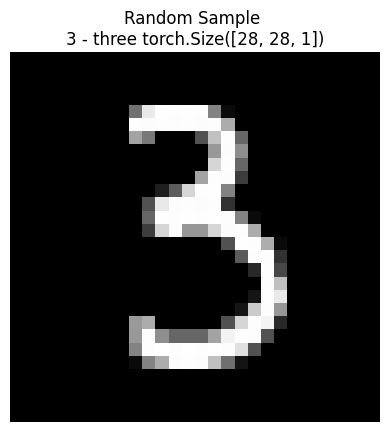

In [26]:
visualize_random_sample_dataset(train_dataset)

## 4. Build model without convolutions or maxpool

In [27]:
class MNISTDigitsModel0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.dense_block = nn.Sequential(
        nn.Flatten(),
        # FCN(Fully Conected Network)
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        #nn.Softmax() # CrossEntropyLoss expects the logits values, not probabilities
    )

  def forward(self, x):
    return self.dense_block(x)

In [28]:
model_0 = MNISTDigitsModel0(input_shape=28*28, hidden_units=15, output_shape=len(classes))
model_0.to(device)

MNISTDigitsModel0(
  (dense_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=15, bias=True)
    (2): ReLU()
    (3): Linear(in_features=15, out_features=15, bias=True)
    (4): ReLU()
    (5): Linear(in_features=15, out_features=10, bias=True)
  )
)

In [29]:
summary(model_0, input_size=(28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 15]          11,775
              ReLU-3                   [-1, 15]               0
            Linear-4                   [-1, 15]             240
              ReLU-5                   [-1, 15]               0
            Linear-6                   [-1, 10]             160
Total params: 12,175
Trainable params: 12,175
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.05
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


##5. Train and test our model 0

In [30]:
# Loss function
loss_fn0 = nn.CrossEntropyLoss()

# Optimzer Adam
optimizer0 = torch.optim.Adam(model_0.parameters(), lr=1e-3)

###5.1 Going Modular, train and test functions

In [31]:
def train_step(model: nn.Module, train_data: DataLoader, loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer, device=device):

  """Forward once through train dataset, one epoch"""

  # Send the model to right device
  model.to(device)

  # Loss and accuracy
  loss_train, acc_train = 0, 0
  accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)


  # Train for each batch
  for batch, (x, y) in enumerate(train_data):
    model.train()

    # Send data to target device
    x, y = x.to(device), y.to(device)

    # 1. Do the forward pass
    y_logits = model(x)

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y)
    loss_train += loss
    acc_train += accuracy(torch.softmax(input=y_logits, dim=1).argmax(dim=1), y)

    # 3. Zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    #  5. Optimizer step
    optimizer.step()

  # Avetage metrics
  loss_train /= len(train_data)
  acc_train /= len(train_data)

  print(f"Train Loss: {loss_train} | Train Acurracy: {acc_train}")
  return loss_train, acc_train

In [32]:
def test_step(model: torch.nn.Module, test_data: DataLoader, loss_fn: torch.nn.Module, device=device):
  # 1. Send the model to target device
  model.to(device)

  # 2. Model in eval
  model.eval()

  # 3. Metrics
  loss, acc = 0, 0
  accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)


  # 4. Loop through each batch
  for batch, (x, y) in enumerate(test_data):
    # 5. Send data to right device
    x, y = x.to(device), y.to(device)


    # 6. Forward in inferece mode
    with torch.inference_mode():
      y_logits = model(x)

      loss += loss_fn(y_logits, y)
      acc += accuracy(y, torch.softmax(y_logits, dim=1).argmax(dim=1))

  loss_test = loss / len(test_data)
  acc_test = acc / len(test_data)

  print(f"Test Loss: {loss_test} | Test Accuracy: {acc_test}")

  return loss_test, acc_test

In [33]:
# Testing train_step function
# for i in range(10):
#   train_step(model=model_0,
#             train_data=train_dataloader,
#             loss_fn=loss_fn0,
#             optimizer=optimizer0,
#             device=device)

In [34]:
# Test the test_step function
# for i in range(10):
#   test_step(model=model_0,
#             test_data=test_dataloader,
#             loss_fn=loss_fn0,
#             device=device)

In [35]:
def train(model: nn.Module,
          train_data: DataLoader,
          test_data: DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int=5,
          device=device):

  # Results dict
  results = {
      'train_loss' : [],
      'test_loss' : [],
      'train_acc' : [],
      'test_acc' : []
  }

  # "For epoch in a range..."
  for epoch in tqdm(range(epochs)):
    print(f"\nEpoch: {epoch}\n")
    # Train
    train_loss, train_acc = train_step(model=model,
                                      train_data=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      device=device)

    # Test
    test_loss, test_acc = test_step(model=model,
                                    test_data=test_data,
                                    loss_fn=loss_fn,
                                    device=device)

    # Get results per epoch
    results['train_loss'].append(train_loss.cpu().detach())
    results['test_loss'].append(test_loss.cpu())
    results['train_acc'].append(train_acc.cpu())
    results['test_acc'].append(test_acc.cpu())

  return results

In [36]:
results = train(model=model_0,
          train_data=train_dataloader,
          test_data=test_dataloader,
          loss_fn=loss_fn0,
          optimizer=optimizer0,
          epochs=10,
          device=device)

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 0

Train Loss: 0.5602271556854248 | Train Acurracy: 0.8329166769981384
Test Loss: 0.3037969172000885 | Test Accuracy: 0.9125398993492126

Epoch: 1

Train Loss: 0.2769036293029785 | Train Acurracy: 0.9201333522796631
Test Loss: 0.24711713194847107 | Test Accuracy: 0.9287140369415283

Epoch: 2

Train Loss: 0.23864266276359558 | Train Acurracy: 0.9318333268165588
Test Loss: 0.23064710199832916 | Test Accuracy: 0.9326078295707703

Epoch: 3

Train Loss: 0.21823664009571075 | Train Acurracy: 0.9373166561126709
Test Loss: 0.21223491430282593 | Test Accuracy: 0.9371006488800049

Epoch: 4

Train Loss: 0.20331190526485443 | Train Acurracy: 0.9409833550453186
Test Loss: 0.22296975553035736 | Test Accuracy: 0.9344049096107483

Epoch: 5

Train Loss: 0.19189384579658508 | Train Acurracy: 0.9437833428382874
Test Loss: 0.2022683173418045 | Test Accuracy: 0.9413937330245972

Epoch: 6

Train Loss: 0.18204033374786377 | Train Acurracy: 0.9465166926383972
Test Loss: 0.19904066622257233 | Test Accu

In [37]:
results

{'train_loss': [tensor(0.5602),
  tensor(0.2769),
  tensor(0.2386),
  tensor(0.2182),
  tensor(0.2033),
  tensor(0.1919),
  tensor(0.1820),
  tensor(0.1719),
  tensor(0.1646),
  tensor(0.1589)],
 'test_loss': [tensor(0.3038),
  tensor(0.2471),
  tensor(0.2306),
  tensor(0.2122),
  tensor(0.2230),
  tensor(0.2023),
  tensor(0.1990),
  tensor(0.1914),
  tensor(0.1808),
  tensor(0.1887)],
 'train_acc': [tensor(0.8329),
  tensor(0.9201),
  tensor(0.9318),
  tensor(0.9373),
  tensor(0.9410),
  tensor(0.9438),
  tensor(0.9465),
  tensor(0.9494),
  tensor(0.9512),
  tensor(0.9528)],
 'test_acc': [tensor(0.9125),
  tensor(0.9287),
  tensor(0.9326),
  tensor(0.9371),
  tensor(0.9344),
  tensor(0.9414),
  tensor(0.9407),
  tensor(0.9442),
  tensor(0.9472),
  tensor(0.9439)]}

## 6. Loss and Accuracy curves: model 0

In [38]:
def plot_metrics(results: Dict) -> None:
  train_acc = results['train_acc']
  test_acc = results['test_acc']

  train_loss = results['train_loss']
  test_loss = results['test_loss']

  epochs = range(len(results['train_loss']))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot Loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot Accuracy
  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label='train_acc')
  plt.plot(epochs, test_acc, label='test_acc')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

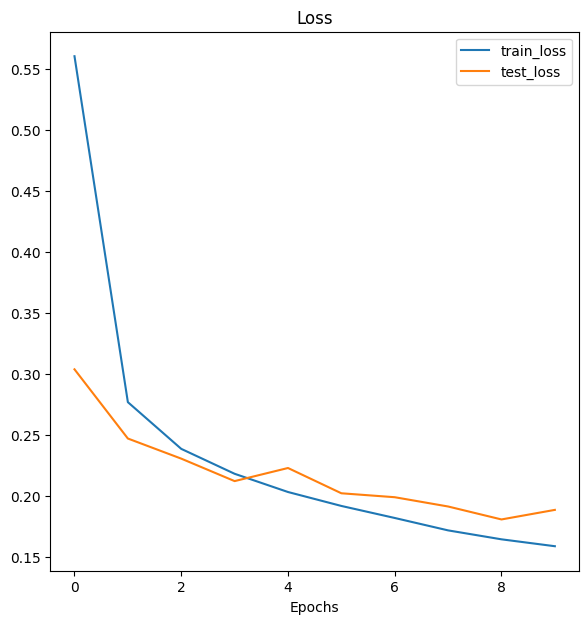

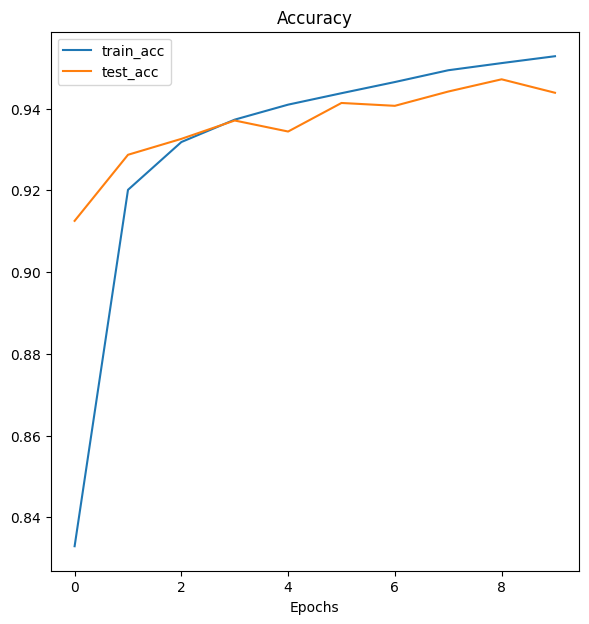

In [39]:
plot_metrics(results)

## 7. Predict test dataset images: model 0

In [100]:
def predict_and_plot(image: torch.Tensor, model):
  with torch.inference_mode():
    pred_label = torch.argmax(torch.softmax(model(image.unsqueeze(dim=0).to(device)), dim=1))
    # print(torch.softmax(model_0(image.unsqueeze(dim=0).to(device)), dim=1))

  image = image.permute(1, 2, 0) # [c, h, w] to [h, q, c]
  plt.imshow(image, cmap='gray')
  plt.title(f"{classes[pred_label]}")
  plt.axis(False)

In [101]:
import random
def random_predict_plot(dataset, model=model_0):
  rand = torch.randint(0, len(dataset), (1,)).item()
  sample, label = dataset[rand]
  predict_and_plot(image=sample, model=model)

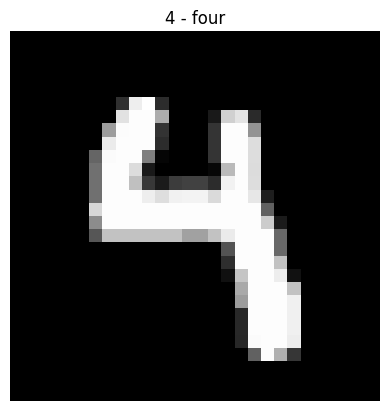

In [102]:
random_predict_plot(test_dataset, model=model_0)

## 8. Using Convolutional Layers With TinyVGG

## 8.1 Build TinyVGG

In [89]:
class TinyVGG(nn.Module):

  def __init__(self, input_shape):
    super().__init__()

    self.flatten = nn.Flatten()

    self.block1 = torch.nn.Sequential(
      nn.Conv2d(in_channels=1,
                out_channels=10,
                kernel_size=(3,3),
                padding='same'),
      nn.ReLU()
    )

    self.block2 = torch.nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride=2)
    )

    self.block3 = torch.nn.Sequential(
      nn.Conv2d(in_channels=10,
                out_channels=10,
                kernel_size=(3,3),
                padding='same'),
      nn.ReLU()
    )

    self.block4 = torch.nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride=2)
    )

    self.head_classifier = nn.Linear(in_features=7*7*10, out_features=10)

  def forward(self, x):
    # print(x.shape)
    # x = self.block1(x)
    # print(x.shape)
    # x = self.block2(x)
    # print(x.shape)
    # x = self.block3(x)
    # print(x.shape)
    # x = self.block4(x)
    # print(x.shape)
    # x = nn.Flatten()(x)
    # print(x.shape)
    # return self.head_classifier(x)

    # Fusion operator
    return self.head_classifier(self.flatten(self.block4(self.block3(self.block2(self.block1(x))))))

In [90]:
model_1 = TinyVGG(input_shape=(28, 28))
model_1 = model_1.to(device)

In [91]:
summary(model_1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
            Conv2d-3           [-1, 10, 28, 28]             910
              ReLU-4           [-1, 10, 28, 28]               0
         MaxPool2d-5           [-1, 10, 14, 14]               0
            Conv2d-6           [-1, 10, 14, 14]             910
              ReLU-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             910
              ReLU-9           [-1, 10, 14, 14]               0
        MaxPool2d-10             [-1, 10, 7, 7]               0
          Flatten-11                  [-1, 490]               0
           Linear-12                   [-1, 10]           4,910
Total params: 7,740
Trainable params: 7,740
Non-trainable params: 0
-----------------------------------

### 8.2 Train model 1: TinyVGG

In [92]:
# Loss and optimizer
loss_fn1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model_1.parameters(), lr=1e-3)

In [93]:
results_1 = train(model=model_1,
          train_data=train_dataloader,
          test_data=test_dataloader,
          loss_fn=loss_fn1,
          optimizer=optimizer1,
          epochs=10,
          device=device)

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 0

Train Loss: 0.24746069312095642 | Train Acurracy: 0.9234166741371155
Test Loss: 0.08645004034042358 | Test Accuracy: 0.9721445441246033

Epoch: 1

Train Loss: 0.08619392663240433 | Train Acurracy: 0.9734166860580444
Test Loss: 0.08372361212968826 | Test Accuracy: 0.9737420082092285

Epoch: 2

Train Loss: 0.06480874121189117 | Train Acurracy: 0.9798333644866943
Test Loss: 0.04656985402107239 | Test Accuracy: 0.9850239157676697

Epoch: 3

Train Loss: 0.053502436727285385 | Train Acurracy: 0.9835667014122009
Test Loss: 0.039787109941244125 | Test Accuracy: 0.9872204065322876

Epoch: 4

Train Loss: 0.04767254367470741 | Train Acurracy: 0.9854166507720947
Test Loss: 0.04135885462164879 | Test Accuracy: 0.9867212176322937

Epoch: 5

Train Loss: 0.04135383293032646 | Train Acurracy: 0.9871833324432373
Test Loss: 0.04420711472630501 | Test Accuracy: 0.9862220287322998

Epoch: 6

Train Loss: 0.037537239491939545 | Train Acurracy: 0.9880499839782715
Test Loss: 0.04396912455558777 | Te

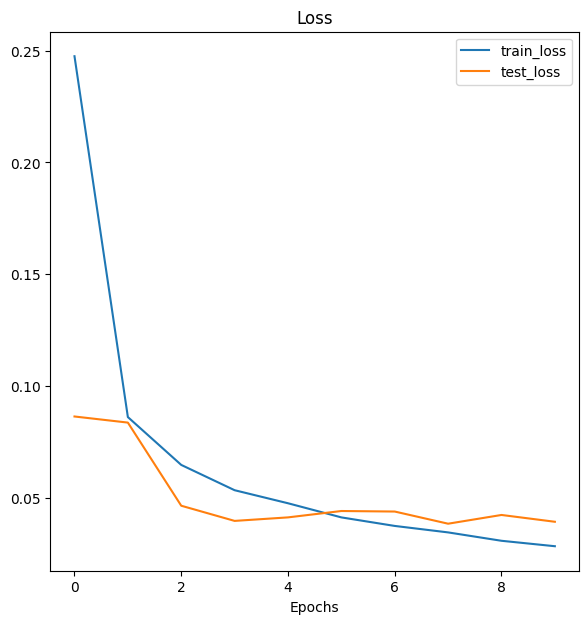

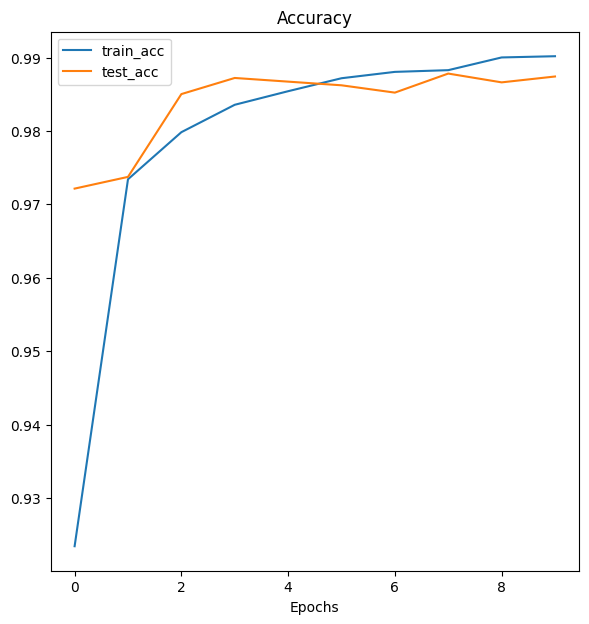

In [94]:
plot_metrics(results_1)

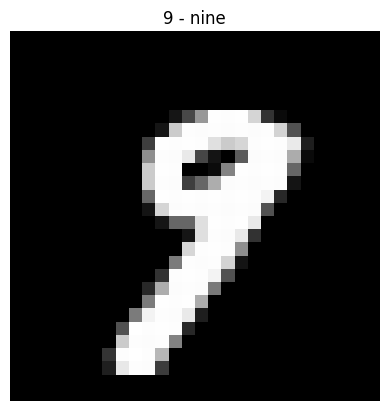

In [104]:
random_predict_plot(test_dataset, model=model_0)